In [ ]:
# Задачи классификации с использованием нейросетей. Часть 2.

## Свёрточные нейронные сети

## Практика. TF

In [ ]:
# Для воспроизводимости кода установим определенную версию tensorflow и keras
!pip install tensorflow==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: keras
    Found existing installation: kera

In [ ]:
!pip install keras==2.11.0

^C


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

Рассмотрим задачу распознавания рукописных цифр.

In [ ]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [ ]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


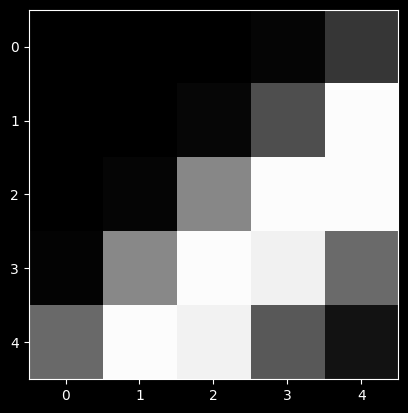

Пример картинки:


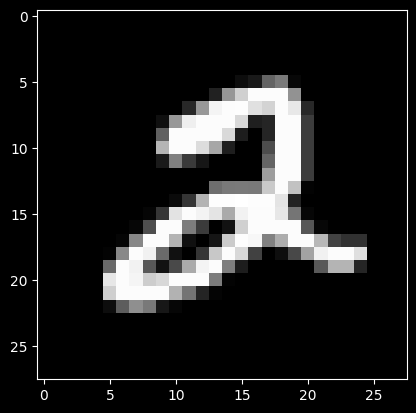

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [ ]:
# Создание и отображение примеров изображений и их меток

# Преобразуем одно изображение из тренировочного набора (например, 5-е) в трехканальное изображение (RGB)
# В этом примере создается трехканальное изображение путем дублирования черно-белого изображения по каждому из каналов (R, G, B)
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))

# Печать части изображения (фрагмент 5 строк и 5 столбцов)
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")  # Отображаем фрагмент изображения с оттенками серого
plt.show()  # Показываем график

# Печать полного изображения
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")  # Отображаем все изображение в оттенках серого
plt.show()  # Показываем график

# Выводим метки классов для первых 10 примеров из тренировочного набора
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])  # Печать формы массива меток и первых 10 меток классов

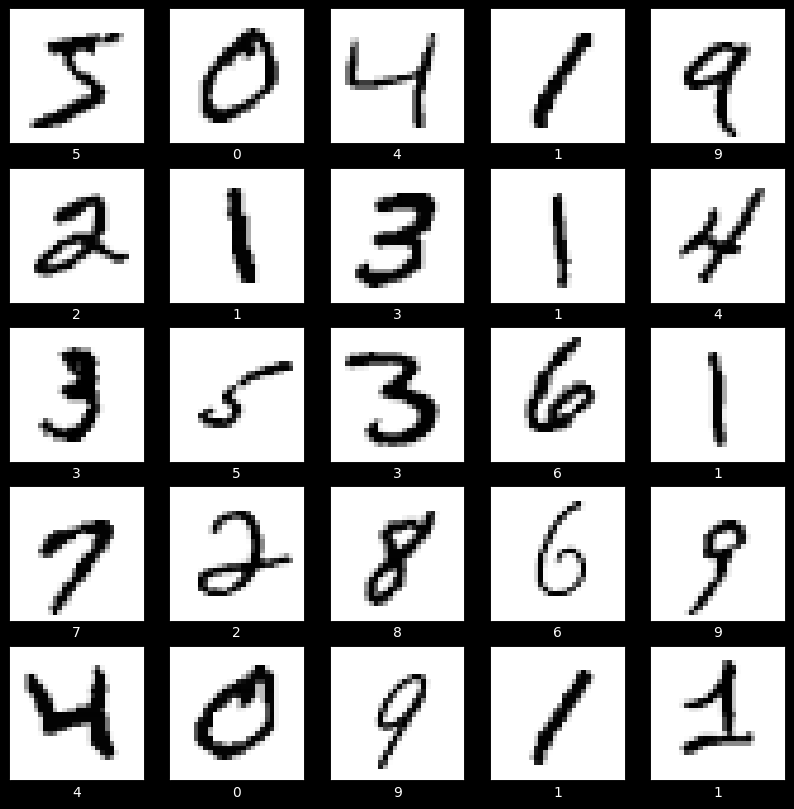

In [ ]:
# Визуализация 25 примеров изображений из тренировочного набора

plt.figure(figsize=(10,10))  # Задаем размер области рисования 10x10 дюймов

# Цикл для отображения 25 изображений (5x5 сетка)
for i in range(25):
    plt.subplot(5,5,i+1)  # Создаем сетку 5x5, в каждой ячейке будет одно изображение
    plt.xticks([])  # Убираем метки по оси X (чтобы убрать лишние детали)
    plt.yticks([])  # Убираем метки по оси Y
    plt.grid(False)  # Отключаем сетку
    plt.imshow(x_train[i], cmap="Greys")  # Отображаем изображение с оттенками серого
    plt.xlabel(y_train[i])  # Подпись под изображением — метка класса (например, цифра, которая изображена)

plt.show()  # Показываем весь рисунок с 25 изображениями

In [ ]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float) # Преобразуем тренировочные данные в векторы
print(x_train.shape, x_train_flat.shape) # Выводим формы оригинального и преобразованного массива

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [ ]:
# центрируем и нормируем, так сети будет проще учиться
# Делим значения пикселей на 255, чтобы нормализовать их в диапазон [0, 1]
# Вычитаем 0.5, чтобы центрировать данные вокруг 0 (диапазон [-0.5, 0.5])

x_train_float = x_train_flat.astype(float) / 255 - 0.5
x_val_float = x_val_flat.astype(float) / 255 - 0.5

In [ ]:
# one-hot encode для ответов
# Преобразуем метки классов y_train и y_val в формат one-hot
# Каждая метка будет представлена бинарным вектором длины 10 (по количеству классов)
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape) # Выводим форму one-hot закодированных меток
print(y_train_oh[:5], y_train[:5]) # Выводим первые 5 one-hot меток и соответствующие оригинальные метки для проверки

(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]] [5 0 4 1 9]


### Собираем модель

Построим простой Multi layer Perceptron (MLP) классификатор в Keras (по аналогии со знакомым нам уже MLPClassifier из sklearn)

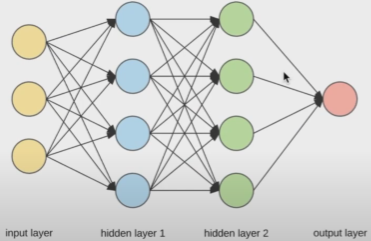

Сначала надо будет посчитать логиты (logit, линейное преобразование) $z_k$ для каждого класса: $$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

А затем превратить логиты $z_k$ в вероятности $p_k$ при помощи функции softmax: $$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Мы будем использовать cross-entropy для минимизации ошибки: $$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$

где $$ [x]=\begin{cases} 1, \quad \text{если $x$ истина} \\ 0, \quad \text{иначе} \end{cases} $$

Минимизация cross-entropy двигает $p_k$ в сторону 1 когда $y = k$, что как раз мы и хотим.


In [ ]:
clear_session()

In [ ]:
# Архитектура сети
model = Sequential() # Определяем модель как последовательную (слои добавляются один за другим)

# Первый скрытый слой (Dense): 256 нейронов, активация ReLU
# Input_shape задает размер входных данных (размерность признаков), равный числу пикселей (784)
model.add(Dense(256, activation='relu', input_shape=(x_train_float.shape[1],)))

# Второй скрытый слой (Dense): 128 нейронов, активация ReLU
model.add(Dense(128, activation='relu',))

# Выходной слой (Dense): 10 нейронов (по одному для каждого класса), активация softmax для предсказания вероятностей
model.add(Dense(10, activation='softmax',)) # выходной слой

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2280 - accuracy: 0.9343 - val_loss: 0.1102 - val_accuracy: 0.9658
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0893 - accuracy: 0.9730 - val_loss: 0.0950 - val_accuracy: 0.9698
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0591 - accuracy: 0.9820 - val_loss: 0.0763 - val_accuracy: 0.9769
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0435 - accuracy: 0.9863 - val_loss: 0.0714 - val_accuracy: 0.9775
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.0319 - accuracy: 0.9891 - val_loss: 0.0738 - val_accuracy: 0.9788
Epoch 6/10
938/938 [==============================] - 5s 6ms/step - loss: 0.0276 - accuracy: 0.9906 - val_loss: 0.0829 - val_accuracy: 0.9763
Epoch 7/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0221 - accuracy: 0.9930 - val_loss: 0.0829 - val_accuracy: 0.9795
Epoch 

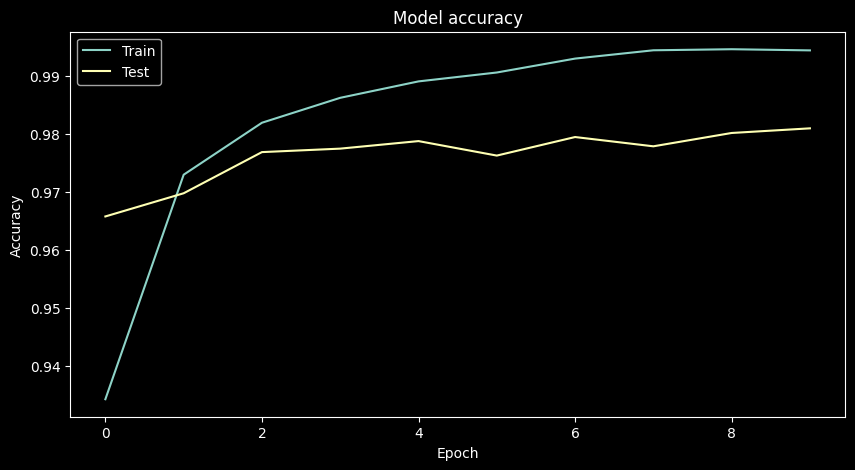

In [ ]:
# Визуализация значений точности (accuracy) на тренировочных и валидационных данных
# plt.style.use(['dark_background']) # Устанавливаем стиль графика (темный фон)
fig, ax = plt.subplots(figsize=(10, 5)) # Создаем объект фигуры и осей с размером 10x5 дюймов

# Строим графики точности модели на тренировочных и валидационных данных
plt.plot(history.history['accuracy']) # Точность на тренировочных данных
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

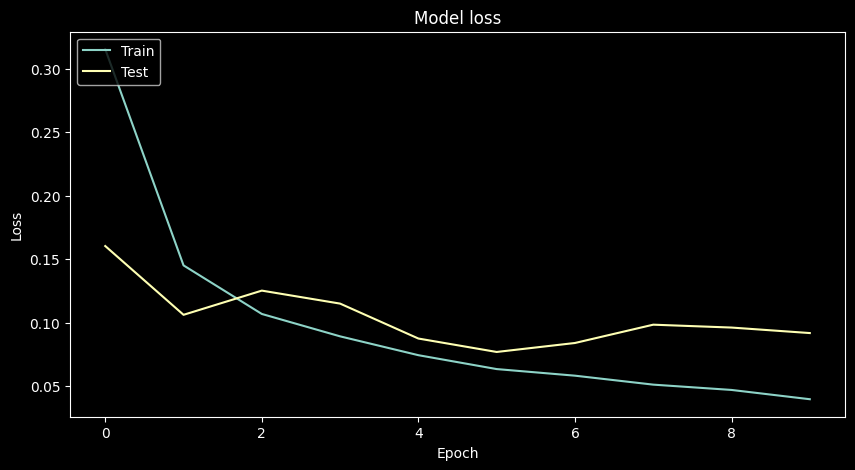

In [ ]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Прогнозирование классов для валидационных данных
model.predict(x_val_float)


313/313 [==============================] - 1s 2ms/step


array([[7.4691675e-10, 2.4668501e-10, 1.0589029e-06, ..., 9.9999875e-01,
        4.5757340e-09, 2.0408688e-08],
       [6.8182114e-12, 8.0279699e-07, 9.9996752e-01, ..., 5.6975275e-11,
        1.4126005e-11, 2.3334280e-21],
       [1.0050170e-07, 9.9991542e-01, 3.6289571e-06, ..., 4.0614865e-05,
        5.2539087e-07, 1.1634189e-07],
       ...,
       [7.4341035e-20, 1.1607157e-14, 1.9179546e-17, ..., 2.3859398e-10,
        3.4759383e-12, 1.9464510e-08],
       [2.6271260e-07, 1.1057960e-09, 1.7013544e-08, ..., 2.0162160e-08,
        5.9910299e-06, 3.3444924e-11],
       [2.4435090e-10, 9.5193627e-12, 1.3946063e-09, ..., 4.0353975e-12,
        1.2446122e-08, 1.2888968e-10]], dtype=float32)

Возвращает предсказания модели для каждого образца в x_val_float. Поскольку это многоклассовая задача классификации, предсказание для каждого образца будет представлено в виде вектора вероятностей для каждого класса.

In [ ]:
# финальные предсказанные классы
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 1s 2ms/step


array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
model.predict(x_val_float)[0]

313/313 [==============================] - 1s 4ms/step


array([7.46916751e-10, 2.46685006e-10, 1.05890285e-06, 1.17714784e-07,
       5.30810530e-13, 5.57857271e-09, 2.91571000e-14, 9.99998748e-01,
       4.57573401e-09, 2.04086881e-08], dtype=float32)

In [ ]:
# Прогнозируем метки классов для валидационных данных
predicts = np.argmax(model.predict(x_val_float), axis = 1)

# Выводим точность на тестовых (валидационных) данных
print('Test Accuracy: ', accuracy_score(y_val, predicts))

313/313 [==============================] - 1s 2ms/step
Test Accuracy:  0.9733


### ДЗ


1.   Обучите сеть без скрытых слоев (постройте аналог обычной линейной модели). Какое accuracy вы получили на валидации?
2.   Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. Какое accuracy на валидации получили?




#### Как компьютер воспринимает картинку?

Любая картинка состоит из пикселей, а в каждом пикселе закодирована яркость — это число от 0 до 255. Яркость 0 означает чёрный цвет, а значение 255 — белый.

Для примера возьмём картинку и очень сильно её увеличим. После этого станут отчётливо видны пиксели, которые имеют различные яркости.



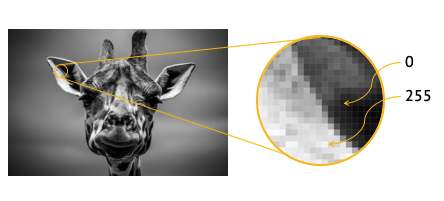

В данном случае у нас чёрно-белая картинка, и пиксели выглядят чёрными, белыми и серыми. При работе с цветными изображениями всё становится несколько сложнее, потому что яркость будет определена для каждого из трёх цветовых каналов RGB (красного, синего, зелёного).

#### Как применять нейросеть к картинке?
Давайте применим уже знакомый нам многослойный перцептрон.



> Многослойный перцептрон (MLP) — это нейронная сеть прямого распространения сигнала (без обратных связей), в которой входной сигнал преобразуется в выходной, проходя последовательно через несколько слоев.


Пусть на вход у нас поступают пиксели картинки, которые образуют собой двумерную матрицу. Сопоставим каждой ячейке нашей пиксельной матрицы определённый вес, зависящий от яркости, а затем сложим все наши элементы матрицы с этими весами и проведём через сигмоиду, как мы это обычно делаем в простом нейроне.

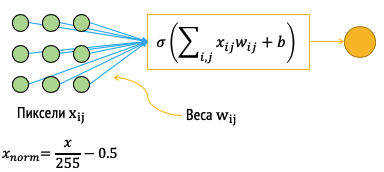

При таком подходе могут возникнуть проблемы:

1. Картинка может быть очень большого размера. Допустим, если картинка имеет размеры 300 x 300, то нам нужно 90 000 весов (это очень много).

2. Допустим, мы хотим определять, изображён ли на картинке котик.
Возьмём картинку, на которой котик изображён в правом нижнем углу. Во время градиентного спуска немного изменятся веса, которые смотрят непосредственно на этого котика (на этой картинке — красные веса).


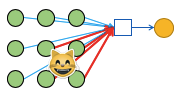

Но если мы возьмём другую картинку, на которой котик будет находиться в левом верхнем углу, то у нас при градиентном спуске немного изменятся зелёные веса, потому что котик будет находиться в другой части картинки.


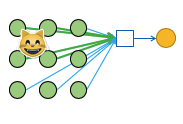

Таким образом, котик в разных частях картинки приводит к обновлению различных весов, хотя эти веса должны научиться находить на картинке одно и то же животное. Получается, что мы не полностью используем те данные для обучения, которые у нас есть.  Если бы у нас была выборка картинок только с котиками в правом нижнем углу, мы бы никогда не научились находить котиков на картинках, на которых они расположены в левом верхнем углу.


Это проблема, так как мы должны учить те же самые признаки кота, не важно где он изображен на картинке.

### Операция свёртки

Получается, рассмотренный выше способ нам не подходит.

К счастью, для такого рода анализа изображений существует **операция свёртки.**

#### Как работает операция свёртки?

Пусть на вход подаётся изображение, которое состоит из 0 и 1 (так нам будет удобнее устно считать и и понимать, как именно работает свёртка), и пусть имеется скользящее окно фиксированного размера (в нашем случае 2 × 2). Нашим окошком 2 × 2 мы пробегаем по изображению и каждый кусочек, по которому пробегает окошко, поэлементно умножаем на некоторые веса и складываем. То есть получаем скалярное произведение нашего кусочка изображения и фильтра, состоящего из весов, которые мы будем обучать.

Рассмотрим первый шаг, где применяется поэлементное умножение, после чего остается только 1 и 4. После сложения этих цифр, получаем 5.

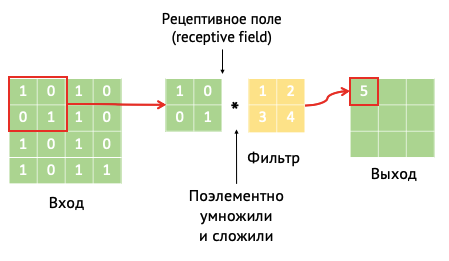

Будем постепенно передвигать окошко и получать некие выходные данные. На картинке ниже показан один из шагов вычислений:

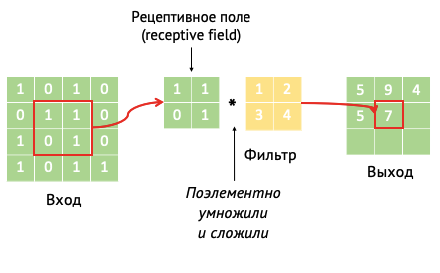

На самом деле, про свёртки известно очень давно. В любом редакторе, например, в Photoshop, есть реализации свёрток.

**Раасмотрим полезность свертки:**

**Пример № 1**

Пусть на вход подаётся картинка. Она пропускается через фильтр 3 × 3, у которого по центру стоит число 8, а во всех остальных ячейках –1 (сумма элементов равна 0).

Если этому фильтру подать на вход изображение, которое является однотонной заливкой, то, поэлементно умножив все яркости на коэффициенты и сложив, мы получим 0, который соответствует чёрному цвету. Те места, где заливка неоднотонная (есть перепад яркости), будут восприниматься как граница некоторых объектов, и значение в этих ячейках будет отлично от 0.

В результате свёртки получаем картинку с подсвеченными краями.

In [ ]:
# 25


# 25 25 25
# 25 25 25
# 25 25 25
# = 25 * 8 *(-1) + 25 * 8 = 0 -- black

# 12 12 8
# 12 8 25
# 8 25 25
# = 12 * (-1) + 12 * (-1) + 8 * (-1)
# + 12 * (-1) + 16 * 8 + 25 * (-1)
# + 8 * (-1) + 25 * (-1) + 25 * (-1) = 59

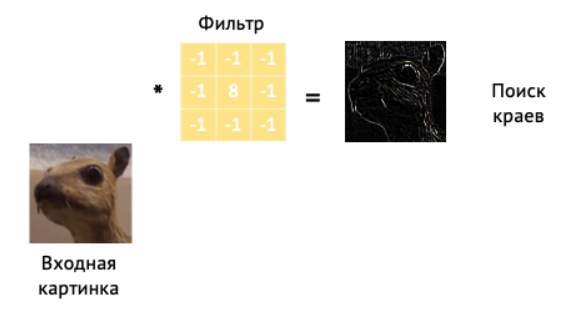

**Пример № 2**

Рассмотрим другой фильтр, сумма весов которого равна 1. Это значит, что при однотонной заливке этот фильтр не будет менять цвет. Когда мы будем на границе объекта на изображении, у нас будет повышаться яркость. Визуально это будет восприниматься как увеличение резкости.

Существует фильтр и для обратной операции — размытия. Такой фильтр состоит из одинаковых элементов и усредняет все цвета, которые видит.

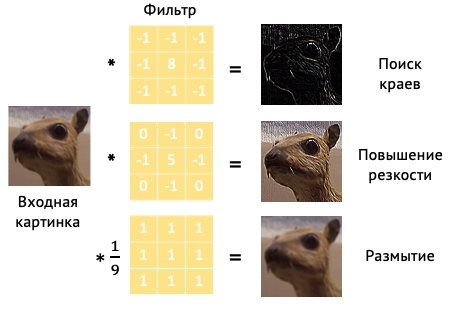

#### Вопросы:

1. Для чего нужные сверточные нейросети?
2. Как работает операция свертки?

### Простой свёрточный слой

#### Как реализовать простой свёрточный слой в нейросети?

Для начала нужно разобраться, как это поможет нам искать на картинках определённые объекты (кошек, собак, уток).

Рассмотрим пример. Пусть на картинке у нас расположена чёрточка под углом, и нам нужно научиться находить её на картинке. Тогда возьмём в качестве фильтра эту же чёрточку.

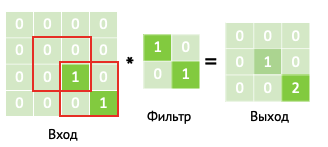

Заметим, что после применения операции ненулевые значения на выходе будут только для двух положений скользящего окна (положения обозначены красной рамкой).

Посмотрим, как будет работать свёртка с картинкой, на которой чёрточка повёрнута в другую сторону. Применив операцию свёртки, получим немного другие значения: здесь тоже только два ненулевых значения на выходе, но они меньше, чем в прошлый раз.



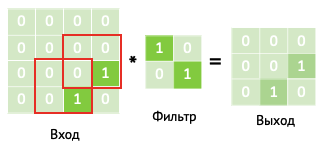

Это говорит нам о том, что на самом деле мы научились определять, что чёрточка на картинке повёрнута.

#### Как теперь понять, куда именно повернута чёрточка?

Нужно просто взять максимум функции — именно он и будет определять поворот нашей чёрточки.

Там, где максимум больше, черточка повернута в нужном нам направлении.

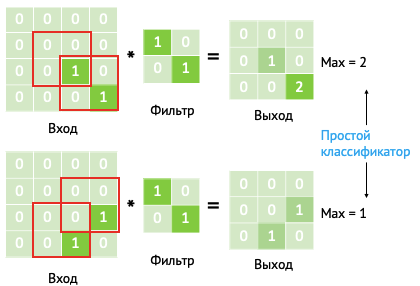

*Максимум функции — простой классификатор для изображений.*

Данный классификатор обладает некоторыми полезными свойствами. Например, свёртка и сдвиг **коммутативны** (если эти операции поменять местами, то результат не изменится).

Посмотрим на примере, что произойдет на выходе, если чёрточка на изображении переместится в другой угол.

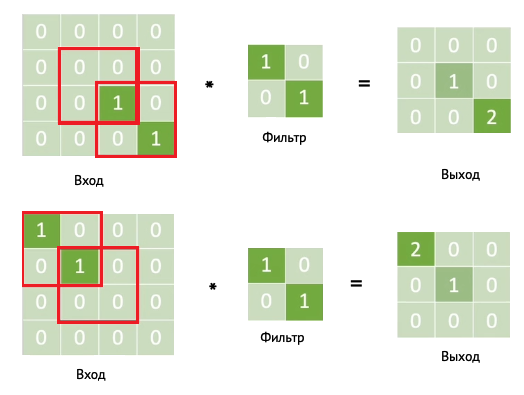

In [ ]:
# 1 0 * 1 0
# 0 1   0 1  = 1 * 1 + 0 * 0 + 0 * 0 + 1 * 1 = 2


# 0 0
# 1 0 =

Снова получим для обоих случаев лишь два ненулевых положения окна. Причём для обоих случаев результат одинаков (только сдвинут). Это означает, что неважно, что делать вначале, сдвиг или свёртку — результат всё равно будет одинаков.

Это важный и полезный результат, так как в нашем классификаторе максимум одинаков. То есть неважно, где будет расположен котик на картинке (в левом верхнем или в правом нижнем углу), мы всё равно будем знать, что это котик.

Теперь мы можем собрать свёрточный слой в нейросети.

#### Как это работает?

На вход подаётся зелёная картинка 3 × 3 с некой рамкой по бокам (обычно она заполнена нулями), называемой padding, или добавкой, необходимой для того, чтобы мы смогли поместить столько окошек, какого размера картинка, чтобы картинка осталась такого же размера за счёт этой добавки.

У нас есть веса, которые нейросеть будет обучать с помощью градиентного спуска. На картинке ниже показано, как будет посчитан первый нейрон.

Берем красное окошко размером 3 × 3 и веса. Заметим, что применяя свертку, в результате получаем w6 + w8 + w9 и еще некоторый свободный коэффициент b. К этому всему применяем сигмоиду или любую другую функцию активации (нелинейную).


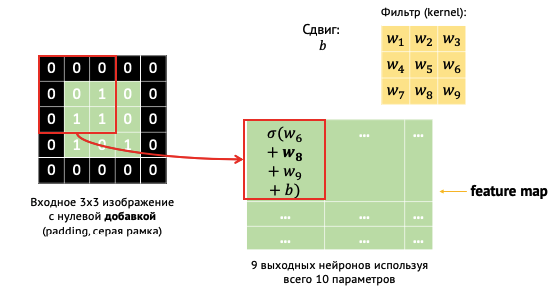

Кроме того, у нас есть ещё один параметр —  шаг (сдвиг, stride), с которым двигается наше скользящее окно. Здесь шаг — 1 пиксель.

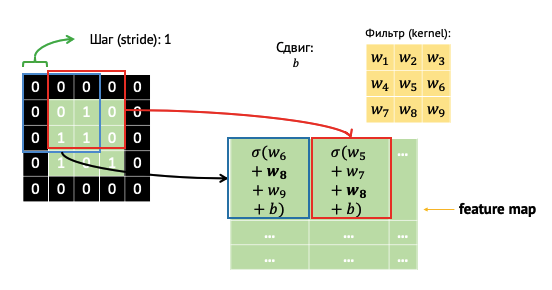

Продолжаем так дальше и на выходе получаем также картинку 3 × 3 — результат свёртки, называемый feature map (карта фичей).

Заметим, что для этого преобразования мы использовали всего 10 параметров (9 весов и 1 шаг).

#### Как работает градиентный спуск для операции свёртки?

На самом деле свёрточный слой — частный случай полносвязного.

Представим, что веса, находящиеся вне нашего поля обзора, просто занулены. И тогда имеем полносвязный слой, а для полносвязного слоя мы уже умеем считать производную.

#### Как считать производную для свёрточного слоя?

Возьмём картинку 3 × 3 и фильтр 2 × 2. На этой картинке есть всего четыре возможных положения фильтра. Последим за одним параметром w4. Нам интересно взять производную нашей функции потерь именно по этому параметру. Все использования нашего параметра в сети назовём различными буквами (a, b, c, d) и будем считать по ним производную.

Чтобы сделать шаг по градиенту, необходимо будет посчитать производную потери по каждой из этих букв. Сдвинем каждый параметр по направлению антиградиента, но если вспомнить что a, b, c, d — это не разные параметры, а один и тот же, то становится понятно, как на самом деле работает градиентный спуск для свёртки: мы четыре раза обновили один и тот же параметр и обновили его на сумму градиентов по всем использованиям на нашей картинке.

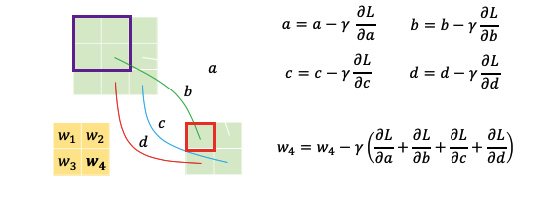

Ещё одним плюсом свёрточного слоя является то, что для его реализации нужно очень мало параметров. Пусть у нас имеется картинка 300 × 300, и на выходе мы хотим получить картинку такого же размера. В случае с полносвязным слоем нам необходимо 8.1 * 10^9 параметров, в то время как в случае со свёрточным слоем и окном 5 × 5 — всего 25 параметров.

## Практика. Простой свёрточный слой

В данной практике мы посмотрим, как в Keras настроить свёрточную сеть, а точнее — как добавить свёрточный слой в нашу сеть.
Мы будем использовать Fashion MNIST.

> Fashion MNIST содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого.

### Свертки в Keras

In [ ]:
!pip install -q tensorflow

In [ ]:
import numpy as np  # Импорт библиотеки для работы с массивами и векторной алгеброй
from sklearn.metrics import accuracy_score  # Импорт функции для оценки точности модели
from matplotlib import pyplot as plt  # Импорт библиотеки для визуализации данных

# Настройка для отображения графиков непосредственно в блокноте (например, в Jupyter)
%matplotlib inline

import tensorflow as tf  # Импорт библиотеки TensorFlow для создания и обучения нейронных сетей
print("We're using TF", tf.__version__)  # Вывод версии TensorFlow
import tensorflow.keras as keras  # Импорт высокоуровневого API Keras для TensorFlow
import tensorflow.keras.models as M  # Импорт функционала для создания моделей в Keras
import tensorflow.keras.layers as L  # Импорт слоев для нейронных сетей в Keras
import tensorflow.keras.backend as K  # Импорт функций для низкоуровневой работы с тензорами и графами в Keras
import pandas as pd  # Импорт библиотеки для работы с данными в табличном виде (DataFrame)

We're using TF 2.11.0


### Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```


In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


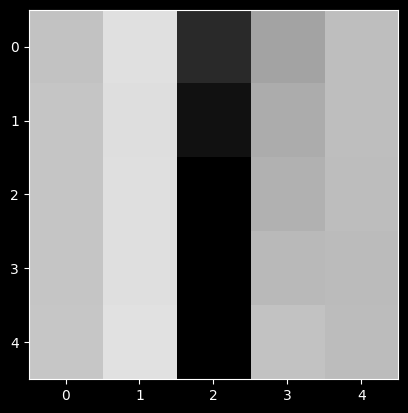

Пример картинки:


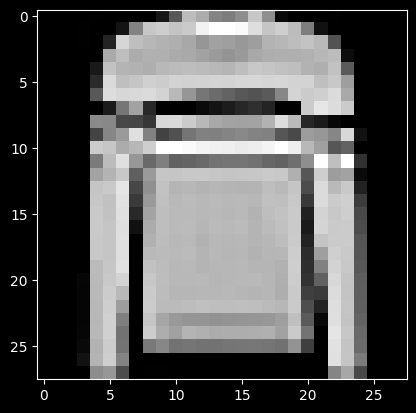

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
# Преобразование изображения для дальнейшей визуализации
# Берем 5-е изображение из набора x_train, изменяем форму и дублируем по 3-му каналу, чтобы создать изображение с 3 каналами (RGB)
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))

# Вывод примера части изображения
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")  # Отображение небольшого фрагмента изображения (с 15 по 20 строку и с 5 по 10 столбец)
plt.show()  # Показать фрагмент изображения

# Вывод всего изображения
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")  # Отображение всего изображения с использованием цветовой карты "Greys" для оттенков серого
plt.show()  # Показать полное изображение

# Вывод первых 10 значений из y_train и информации о форме массива y_train
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])  # Печать формы массива y_train и первых 10 меток (классов) для изображений

In [ ]:
# Применение one-hot кодирования к меткам классов для y_train и y_val
# Преобразуем метки в формат one-hot, где для каждого класса создается бинарный вектор длины 10
y_train_oh = keras.utils.to_categorical(y_train, 10)  # Применение one-hot кодирования к обучающим меткам
y_val_oh = keras.utils.to_categorical(y_val, 10)      # Применение one-hot кодирования к валидационным меткам

# Вывод информации о форме массива one-hot закодированных меток y_train
print(y_train_oh.shape)  # Печать формы массива y_train_oh

# Вывод первых 5 примеров закодированных меток и соответствующих исходных меток
print(y_train_oh[:5], y_train[:5])  # Печать первых 5 one-hot меток и первых 5 исходных меток

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


### Собираем модель

Будем минимизировать кросс-энтропию.

In [ ]:
# Очистка текущего графа и освобождение ресурсов TensorFlow/Keras
K.clear_session()

# Создание новой модели с использованием изображения как входа (без вытягивания в вектор)
model = M.Sequential()  # Определяем модель как последовательную (слои будут добавляться последовательно)

# Добавление сверточного слоя (Conv2D) с 1 фильтром 3x3, шагом 1 и сохранением размерности (padding='same')
# Входной слой принимает изображение размером 28x28 с одним каналом (черно-белое изображение)
model.add(L.Conv2D(1, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))

# Преобразование многомерного тензора в одномерный вектор перед плотным слоем
model.add(L.Flatten())

# Добавление полносвязного (Dense) слоя с 10 нейронами и функцией активации softmax для классификации на 10 классов
model.add(L.Dense(10, activation='softmax'))


In [ ]:
# Вывод краткого описания модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 1)         10        
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,860
Trainable params: 7,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(float) / 255 - 0.5
x_val_float = x_val.astype(float) / 255 - 0.5

In [ ]:
# Обучение модели на тренировочных данных
history = model.fit(
    x_train_float[:, :, :, np.newaxis],  # Тренировочные данные. Добавляем дополнительное измерение (канал) для соответствия входному формату (28x28x1).
    y_train_oh,  # One-hot закодированные метки классов для тренировочных данных.
    batch_size=32,  # Размер мини-выборки (batch size). Модель обновляет свои параметры после каждого мини-пакета из 32 изображений.
    epochs=5,  # Количество эпох — полный цикл обучения на всех тренировочных данных. Модель обучится за 5 эпох.
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)  # Валидационные данные, на которых модель будет проверяться после каждой эпохи.
)

Epoch 1/5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.4061 - accuracy: 0.8575 - val_loss: 0.4522 - val_accuracy: 0.8379
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4014 - accuracy: 0.8604 - val_loss: 0.4537 - val_accuracy: 0.8371
Epoch 3/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3974 - accuracy: 0.8615 - val_loss: 0.4519 - val_accuracy: 0.8370
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3923 - accuracy: 0.8631 - val_loss: 0.4573 - val_accuracy: 0.8368
Epoch 5/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3899 - accuracy: 0.8633 - val_loss: 0.4524 - val_accuracy: 0.8408


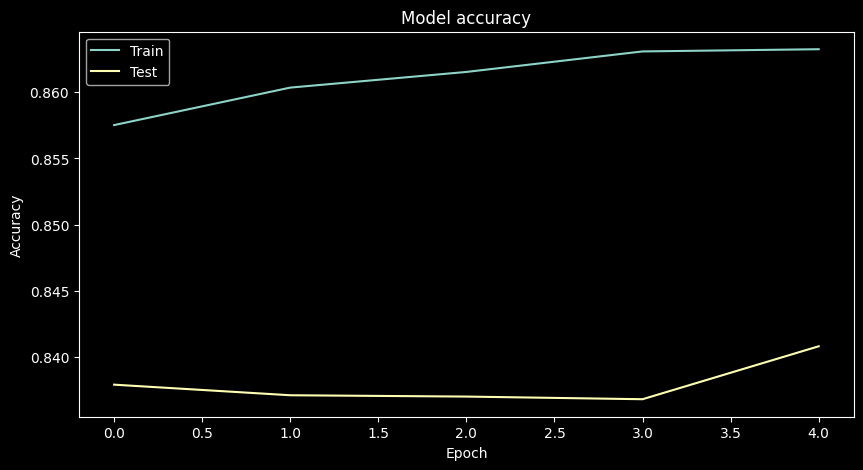

In [ ]:
# Визуализация значений точности (accuracy) на тренировочных и валидационных данных
# plt.style.use(['dark_background']) # Устанавливаем стиль графика (темный фон)
fig, ax = plt.subplots(figsize=(10, 5)) # Создаем объект фигуры и осей с размером 10x5 дюймов

# Строим графики точности модели на тренировочных и валидационных данных
plt.plot(history.history['accuracy']) # Точность на тренировочных данных
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

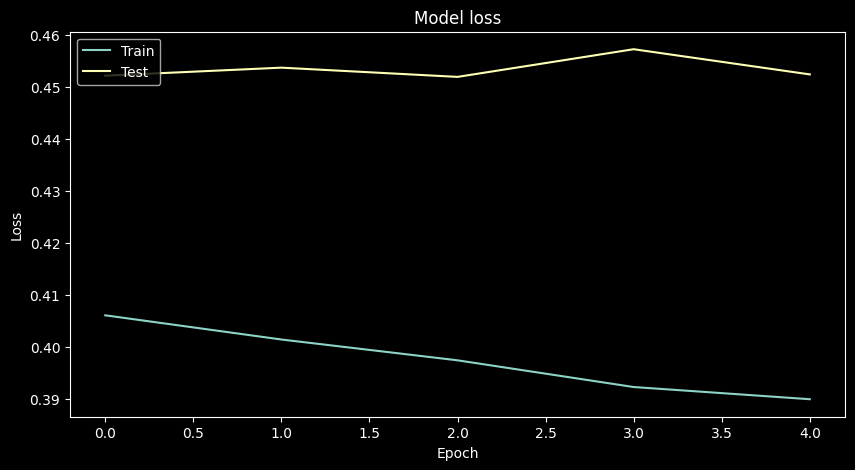

In [ ]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()